In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import math
import seaborn as sns
import os

# %config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

sc.settings.verbosity = 0
sc.logging.print_header()
sns.set_context("paper")

/home/serhiy/Desktop/code/2_single_cell/dulac_kaplan2023_dev_regulation_snRNAseq_scATACseq_mouse_hbc04623/data/hotspot_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.2 anndata==0.8.0 umap==0.5.3 numpy==1.22.3 scipy==1.8.1 pandas==1.5.3 scikit-learn==1.2.1 statsmodels==0.13.5 pynndescent==0.5.8


In [2]:
import warnings
warnings.simplefilter( action="ignore", category=FutureWarning)

In [3]:
# import local module containing misc code, helps keep notebooks clean from commonly used functions
import sys
#sys.path.insert(0, '/scratchfs/cherring/brain_maturation/analysis/submittal_final/')
import new_misc_code as nmc

## **Load log2 CPM pseudo-bulk and GAM fit data pickles**

In [4]:
# load log2 TMM pseudo-bulked data from limma-voom
# logTMMs.pkl was saved in 11__dev-DEGs_age-trend-fits_rate-of-change.ipynb
# logTMMs = nmc.load_obj("data/dev_deg_v6/logTMMs.pkl")
logTMMs = nmc.load_obj("data/dev_deg_v8/logTMMs.filtered100.pkl")
# logTMMs = nmc.load_obj("data/dev_deg_v4/logTMMs.pkl")
# GAM fits from 12__major-trajectory_dev-DEGs_stage-trend-fits.ipynb
# good_fits = nmc.load_obj("data/dev_deg_v6/AGE_gam_fits_12_grid100.pkl")
# good_fits = nmc.load_obj("data/dev_deg_v4/AGE_gam_fits_12_grid100.pkl")
good_fits = nmc.load_obj("data/dev_deg_v8/AGE_gam_fits_12_grid100.filtered100.pkl")

In [5]:
# read in anndata for obs
# adata = sc.read_h5ad("data/2023-05-16_input/seurat.excitatory_select.h5ad")
# adata = sc.read_h5ad("data/2023-05-16_input/seurat.inhibitory_select.h5ad")
adata = sc.read_h5ad("data/2023-05-16_input/seurat.merged.h5ad")
obs_df = adata.obs.copy()
# clean up dataframe by dropping all duplicates of batch entries
#obs_df.drop_duplicates( subset='batch', keep="first", inplace=True)

## Read in GO terms from maturation DEGs for each major cluster

In [6]:
# enriched categories for each cell type
#mat_degs = nmc.load_obj( "data/dev_deg_v6/devDEG_Gene-Ontology-hits.pkl")
mat_degs = nmc.load_obj("data/dev_deg_v8/devDEG_Gene-Ontology-hits.pkl")
# mat_degs = nmc.load_obj("data/dev_deg_v4/devDEG_Gene-Ontology-hits.pkl")
# mat_degs.keys()
# mat_degs['i-B1']['name']
# mat_degs = mat_degs['e-A1']
# mat_degs['i-B1']

In [7]:
counts = {}
for k_itr, v_itr in mat_degs.items():
    words = v_itr['name'].values
    for word in words:
        counts[word] = counts.get(word, 0) + 1
        
pairs = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)
sorted_terms = []
for itr, (word, count) in enumerate(pairs):
    if(count>=0):
        sorted_terms.append( f"{word}__{count}")
print(sorted_terms)

['structural constituent of ribosome__110', 'peptide metabolic process__110', 'nuclear-transcribed mRNA catabolic process, nonsense-mediated decay__109', 'protein localization to endoplasmic reticulum__109', 'establishment of protein localization to endoplasmic reticulum__109', 'protein targeting to ER__109', 'translational initiation__109', 'SRP-dependent cotranslational protein targeting to membrane__109', 'cotranslational protein targeting to membrane__108', 'translation__108', 'peptide biosynthetic process__108', 'nuclear-transcribed mRNA catabolic process__107', 'protein localization to membrane__107', 'RNA binding__106', 'protein targeting to membrane__106', 'establishment of protein localization to membrane__106', 'amide biosynthetic process__106', 'cellular amide metabolic process__105', 'protein targeting__104', 'viral transcription__103', 'viral gene expression__103', 'nucleobase-containing compound catabolic process__103', 'establishment of protein localization to organelle_

In [8]:
def search_term( term, sorted_terms=sorted_terms):
    return( [ii for ii in sorted_terms if term in ii])

In [9]:
# one_offs_dict['L4_RORB']

### Plot GO terms

In [9]:
# https://biit.cs.ut.ee/gprofiler_archive3/e102_eg49_p15/gost
# go_file_bp = "/scratchfs/cherring/brain_maturation/analysis/first_final_notebooks/maturation_dynamics/new_single_GAM-fit/data/GO_genes_ref_data/hsapiens.GO:BP.name.gmt"
# go_file_mf = "/scratchfs/cherring/brain_maturation/analysis/first_final_notebooks/maturation_dynamics/new_single_GAM-fit/data/GO_genes_ref_data/hsapiens.GO:MF.name.gmt"
go_file_bp = "data/dev_deg/gprofiler/mmusculus.GO:BP.name.gmt"
go_file_mf = "data/dev_deg/gprofiler/mmusculus.GO:MF.name.gmt"

In [10]:
import csv
# array of genes for each GO term
GO_terms = {}
with open(go_file_bp, 'r') as f:
    reader = csv.reader( f, delimiter='\t')
    for row in reader:
#         print( row[2:])
        GO_terms[row[1]] = np.array(row[2:])
with open( go_file_mf, 'r') as f:
    reader = csv.reader( f, delimiter='\t')
    for row in reader:
#         print( row[2:])
        GO_terms[row[1]] = np.array( row[2:])

## Plot some GO terms - mean expression over stages

In [11]:
#color_dict = adata.uns['major_clust_colors_dict']
# color_dict = {'avpe' : "#512568"}
# mj_plot_order = ["e-A1", "e-A2", "e-A3", 
#                 "e-F1",
#                 "e-M1", "e-M2", "e-M3", "e-M4", 
#                 "e-M5", "e-M8", "e-M9", "e-M10",
#                 "e-P1", "e-P2", "e-P3"] 

mj_plot_order = ["i-B1", "i-B2", "i-B3", 
                 "i-H1", "i-H2", "i-H3",
                 "i-M1", "i-M2", "i-M3",
                 "i-M4", "i-M5", "i-M6",
                 "i-M7", "i-M8", "i-M9", 
                 "i-P1", 
                 "i-S1", "i-S2", "i-S3", "i-S4",
                 "i-S5",
                 "i-V1"]
mj_plot_order = sorted(good_fits.keys())

v_colors = ['#ffc857', '#c6d5c0', '#558140', '#6e0614', '#8b3843', '#a86a72',
       '#c59ba1', '#8eab80', '#ecd1c8', '#484848', '#92afc2', '#255f85',
       '#e2cdd0', '#c77459', '#daa290',
       '#ffffff', '#b44622', '#1c5701',
       '#a3a3a3',
       'red', 'yellow', 'lime' ]

color_dict = {}
i = 0
for cell_type in mj_plot_order:
    color_dict[cell_type] = v_colors[i]

### Based on prior knowledge lets clean up the data a bit

PN neurons are largely post mitotic and have migrated to cortical layers by ga22, so removing any PN with a DEG for migration. The positive hit for migration in PNs could be due to the large overlap of genes in migration and dendrite/axon growth. 

In [14]:
#pns = ['L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS', 'L5-6_TLE4']
#for ii in pns:
#    if( np.any( mat_degs[ii]['name']=='cell migration')):
#        print(ii)
#        mat_degs[ii] = mat_degs[ii].loc[~(mat_degs[ii]['name']=='cell migration').values,:]

L2-3_CUX2
L4_RORB
L5-6_THEMIS
L5-6_TLE4


In [15]:
#for ii in pns:
#    if( np.any( mat_degs[ii]['name']=='neuron migration')):
#        print(ii)
#        mat_degs[ii] = mat_degs[ii].loc[~(mat_degs[ii]['name']=='neuron migration').values,:]

L2-3_CUX2
L4_RORB
L5-6_THEMIS
L5-6_TLE4


## Eigenvalues of gene trends

In [12]:
# quantile norm by all trends
df = pd.concat( list( good_fits.values()), keys = list(good_fits.keys()))
df.index.names = ['cell_type','gene']
rank_mean = df.stack().groupby(df.rank(method='first').stack().astype(int)).mean()
all_quant_df = df.rank(method='min').stack().astype(int).map(rank_mean).unstack()
# re-combine into a dict
quant_fits_dict = {}
for key in good_fits.keys():
    #print( key)
    quant_fits_dict[key] = all_quant_df.loc[key]

In [36]:
# quant norm before PCA
def eigen_val(go_term, cell_type, 
              logTMMs = logTMMs, GO_terms = GO_terms, quant_fits = quant_fits_dict):
    #go_term = "oxidative phosphorylation"
    #cell_type = "e-A1"
    inter_genes = np.intersect1d(GO_terms[go_term], logTMMs[cell_type].index)
    # get df with just trends of intersect genes
    trend_df = quant_fits[cell_type].loc[inter_genes]
    # this will return a matrix with rows as time and cols as genes
    tt = trend_df.T
    # Get prinicple components
    go_pcs = sc.pp.pca(tt.to_numpy(), n_comps=2, zero_center=False, return_info=False)
    #go_pcs[:,0]
    return(go_pcs[:,0])

In [15]:
# what should we plot?
#goes = ['neuron migration', 'neuron projection development', 'synapse organization', 'apoptotic process', 
#        'learning or memory', 'ensheathment of neurons', 'ion transport']
goes = ['oxidative phosphorylation',
        'aerobic respiration',
        'ATP synthesis coupled electron transport',
        'ATP biosynthetic process',
        'ribose phosphate metabolic process',
        'generation of precursor metabolites and energy',
        'respiratory electron transport chain',
        'cellular respiration',
        'proton transmembrane transport',
       'ribonucleotide metabolic process',
       'electron transport chain']
#        'oxidoreductase activity'
#       ]
goes = ['cell-cell adhesion via plasma-membrane adhesion molecules',
        'synapse organization', 
        'homophilic cell adhesion via plasma membrane adhesion molecules', 
        'cell junction organization']

# for excitatory cell types
# goes = ['ATP synthesis coupled electron transport',
#        'mitochondrial ATP synthesis coupled electron transport',
#        'oxidative phosphorylation',
#        'respiratory electron transport chain', 
#        'synapse organization', 
#        'cell-cell adhesion via plasma-membrane adhesion molecules', 
#        'modulation of chemical synaptic transmission', 
#        'regulation of trans-synaptic signaling', 
#        'homophilic cell adhesion via plasma membrane adhesion molecules', 
#        'cell junction organization']

# for inhibitory cell types
goes = ['anterograde trans-synaptic signaling', 
        'chemical synaptic transmission', 
        'synapse organization', 
        'trans-synaptic signaling', 
        'synaptic signaling',
        'ATP synthesis coupled electron transport',
        'mitochondrial ATP synthesis coupled electron transport', 
        'respiratory electron transport chain',
        'oxidative phosphorylation', 
        'cellular respiration', 
        'electron transport chain',
        'energy derivation by oxidation of organic compounds', 
        'generation of precursor metabolites and energy', 
        'NAD(P)H dehydrogenase (quinone) activity',
        'NADH dehydrogenase (ubiquinone) activity',     
        'NADH dehydrogenase (quinone) activity']
# for all cell types
# goes = 
goes = ['signaling',
        'signal transduction']


# 'NADH dehydrogenase complex assembly'
# raises errir
# 'oxidoreductase activity, acting on NAD(P)H, quinone or similar compound as acceptor']
# 'mitochondrial respiratory chain complex I assembly'
        
      
# 'ATP synthesis coupled electron transport__5', 
# 'mitochondrial ATP synthesis coupled electron transport__5', 'oxidative phosphorylation__4', 'respiratory electron transport chain__4', 'synapse organization__3', 'cell-cell adhesion via plasma-membrane adhesion molecules__2', 'modulation of chemical synaptic transmission__2', 'regulation of trans-synaptic signaling__2', 'homophilic cell adhesion via plasma membrane adhesion molecules__2', 'cell junction organization__2',

# not plotting - fails
#'respiratory electron transport chain']
# 'mitochondrial ATP synthesis coupled electron t...'
# 'ATP synthesis coupled electron transport'
# ATP metabolic process
#'mitochondrial ATP synthesis coupled electron t...'
#'cellular respiration'

In [45]:
import matplotlib.patches as patches
# There is an annoying ImplicitModificationWarning from anndata that is baked into running scanpy PCA with a non-anndata object. 
# It is thrown repeatedly with this code so I have suppressed warnings. Plot with generate without issue otherwise. 
import warnings
warnings.filterwarnings('ignore')

n_grid_pts = 100
# stage_order = adata.uns['stage_order']
# stage_order =  [0, 1, 2, 3, 4, 5, 6, 7]
stage_order = [16, 18, 20, 24, 30, 38, 48, 85]
xlabels = ["e16", "e18", "p0", "p4", "p10", "p18", "p28", "p65"]
num_stages = len(stage_order)
# get list of cluster hit for each go term
go_celltypes_dict = {}
for gg in goes:
    go_celltypes = []
    for kk, vv in mat_degs.items():
        search_itr = search_term(gg, sorted_terms = vv['name'].values)
        search_mk = [ii==gg for ii in search_itr]
        if(np.any( search_mk)):
            go_celltypes.append(kk)
    # re-order cell types to match paper ordering
    Y = [mj_plot_order.index(ii) for ii in go_celltypes]
    X = go_celltypes
    go_celltypes_dict[gg] = [x for _,x in sorted(zip(Y,X))]
# color scale for expression
cmap = sns.color_palette( "ch:start=.2,rot=-.3", n_colors=20)

# create figure with subplots
n = len(goes)
widths = [0.5,8]
heights = [len(ii) for ii in go_celltypes_dict.values()]
fig = plt.figure( constrained_layout=False, figsize=(sum(widths),sum(heights)/3))
spec = fig.add_gridspec( ncols=2, nrows=n, width_ratios=widths,
                          height_ratios=heights)
spec.update( wspace=0.01, hspace=0.05)

plot_vals_dict = {}
# loop through goes to get average expression
for itr, (go_itr, glc_itr) in enumerate(zip(goes, goes)):
    ax = fig.add_subplot( spec[itr,1])
    df_itr = pd.DataFrame([], 
                          columns=good_fits['i-B1'].columns.values, 
                          index = go_celltypes_dict[glc_itr], 
                          dtype=float)
    # get average trend expression
    for key_itr in go_celltypes_dict[glc_itr]:
        # get eigen value
        #print(glc_itr)
        #print(key_itr)
        df_itr.loc[key_itr] = eigen_val(glc_itr, key_itr)
#         df_itr.loc[key_itr] = trends_avg( GO_terms[go_itr], good_fits[key_itr])
        # normalize rows 0 to 1
        df_itr = df_itr.subtract(df_itr.min(axis=1), axis=0)\
          .divide(df_itr.max(axis=1) - df_itr.min(axis=1), axis=0)\
          .combine_first(df_itr)
    plot_vals_dict[glc_itr] = df_itr
    ### right plot
    # print(cmap)
    cg = sns.heatmap( df_itr, ax=ax, cmap=cmap, xticklabels=False, yticklabels=False, cbar=False)
#     cg.set_title( go_itr, loc='right')
    # remove ticks for subplots
    cg.tick_params( bottom=False)
    # rotate y labels
    plt.setp( cg.yaxis.get_majorticklabels(), rotation=0)
    go_title = go_itr
    ax.text( 1.005, 0.50, go_title, transform=ax.transAxes, ha='left', va='center')
ticks = np.linspace( 1.0, n_grid_pts-1.0, num_stages)
ax.set_xticks( ticks)
ax.set_xticklabels( xlabels, rotation=90);
### left plot
# add color blocks for each major-cluster
for itr, glc_itr in enumerate( goes):
    ax = fig.add_subplot( spec[itr,0])
    cell_list = go_celltypes_dict[glc_itr]
    for i, cell_itr in enumerate( cell_list[::-1]):
        yy = 1 * i
        # Create a Rectangle patch
        rect = patches.Rectangle((0.0,yy), 0.5, 1.0, color=color_dict[cell_itr])
        # Add the patch to the Axes
        ax.add_patch(rect)
    ax.set_xlim(0,0.5)
    ax.set_ylim(0,len(cell_list))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticklabels( cell_list[::-1])
    ax.set_yticks( np.linspace(0.5, len(cell_list)-0.5, len(cell_list)))
# plt.savefig( f"/dd_userdata/usrdat03/userdata/cherring/data/cellranger_outputs/brain_maturation_RNA/out_figs/dynamic-GO-terms_mj-clusts_splines{n_splines}_grids{n_grid_pts}.svg", format='svg', bbox_inches='tight')

ZeroDivisionError: float division by zero

<Figure size 850x0 with 0 Axes>

In [19]:
go_celltypes_dict

{'signaling': [], 'signal transduction': []}

In [20]:
gene_cluster["cell_type"].value_counts()

NameError: name 'gene_cluster' is not defined

In [21]:
print(mj_plot_order)
print(go_celltypes)
Y = [mj_plot_order.index(ii) for ii in go_celltypes]
print(Y)

['e-A1', 'e-A2', 'e-A3', 'e-A4', 'e-A5', 'e-B1', 'e-B2', 'e-C1', 'e-C2', 'e-C3', 'e-C4', 'e-C5', 'e-C6', 'e-C7', 'e-C8', 'e-C9', 'e-F1', 'e-H10', 'e-H2', 'e-H3', 'e-H4', 'e-H5', 'e-H6', 'e-H7', 'e-H8', 'e-H9', 'e-L2', 'e-L3', 'e-L4', 'e-L5', 'e-L6', 'e-L8', 'e-M1', 'e-M10', 'e-M2', 'e-M3', 'e-M4', 'e-M5', 'e-M6', 'e-M7', 'e-M8', 'e-M9', 'e-N1', 'e-N10', 'e-N11', 'e-N2', 'e-N3', 'e-N4', 'e-N5', 'e-N6', 'e-N7', 'e-N8', 'e-N9', 'e-P1', 'e-P2', 'e-P3', 'e-P4', 'e-T1', 'e-T2', 'e-X1', 'i-B1', 'i-B10', 'i-B11', 'i-B13', 'i-B2', 'i-B3', 'i-B4', 'i-B5', 'i-B6', 'i-B7', 'i-B8', 'i-B9', 'i-C1', 'i-C2', 'i-H1', 'i-H10', 'i-H11', 'i-H2', 'i-H3', 'i-H4', 'i-H5', 'i-H6', 'i-H7', 'i-H8', 'i-H9', 'i-L1', 'i-L2', 'i-L3', 'i-L4', 'i-L5', 'i-L6', 'i-L7', 'i-M1', 'i-M10', 'i-M11', 'i-M12', 'i-M2', 'i-M3', 'i-M4', 'i-M5', 'i-M6', 'i-M7', 'i-M8', 'i-M9', 'i-P1', 'i-P2', 'i-P3', 'i-P4', 'i-S1', 'i-S3', 'i-S4', 'i-S5', 'i-S6', 'i-S7', 'i-S8', 'i-V1', 'i-V2', 'i-V3', 'i-V4', 'i-V5', 'i-V6', 'i-V7', 'i-V8', 'i-

In [56]:
good_fits

{'e-A1':                      0         1         2         3         4         5   \
 Xkr4           9.600451  9.583913  9.568115  9.553085  9.538851  9.525441   
 Pcmtd1         7.209317  7.190375  7.173760  7.159570  7.147903  7.138857   
 Gm26901        5.600264  5.571202  5.544242  5.519294  5.496265  5.475064   
 Sntg1          8.581948  8.598201  8.615467  8.633698  8.652849  8.672872   
 Mcmdc2         4.424097  4.445594  4.467654  4.490134  4.512892  4.535787   
 ...                 ...       ...       ...       ...       ...       ...   
 mt-Nd5         6.609749  6.691930  6.772023  6.849654  6.924449  6.996034   
 mt-Cytb        8.140828  8.192906  8.243051  8.290984  8.336423  8.379087   
 Tmlhe          5.104088  5.156975  5.210546  5.264400  5.318134  5.371346   
 AC149090.1     9.573050  9.555724  9.538367  9.521083  9.503974  9.487142   
 B930025P03Rik  3.731957  3.790655  3.847979  3.903855  3.958211  4.010971   
 
                      6         7         8         9 

In [100]:
spec[0, 1]

GridSpec(1, 2, width_ratios=[0.5, 8])[0:1, 1:2]

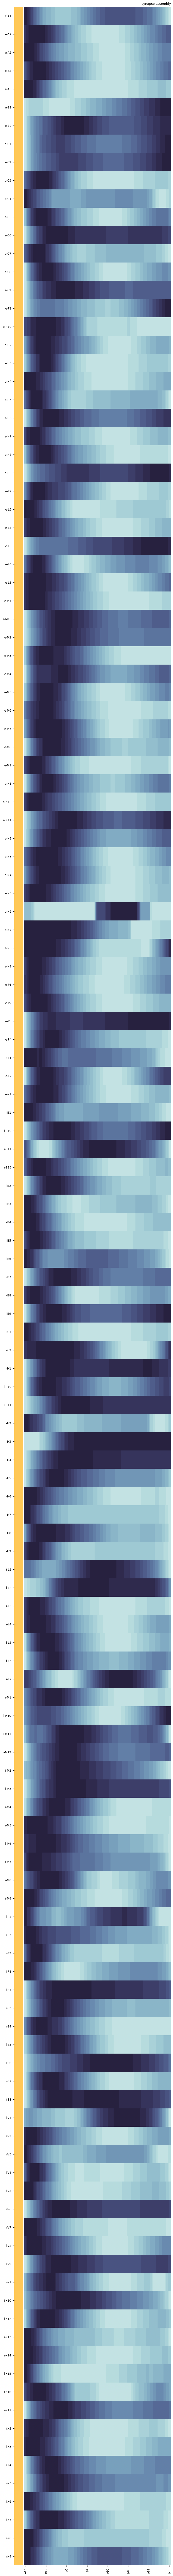

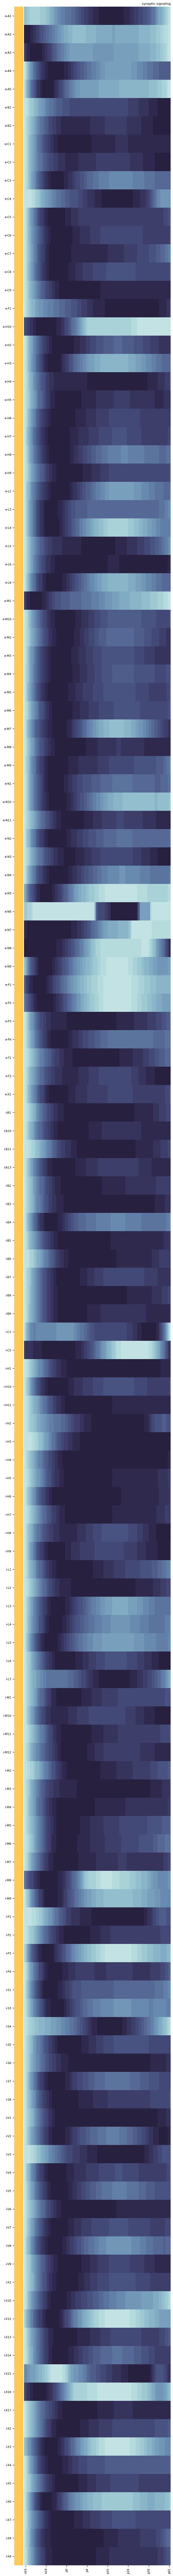

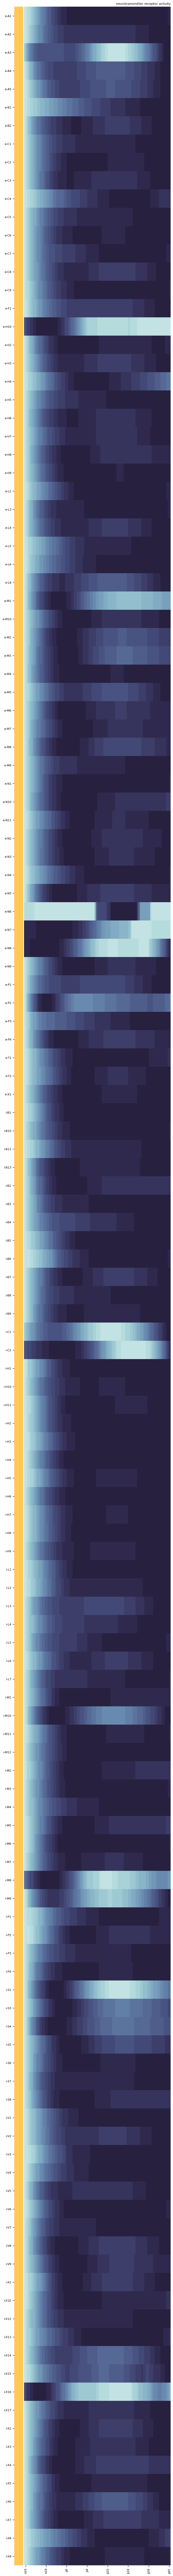

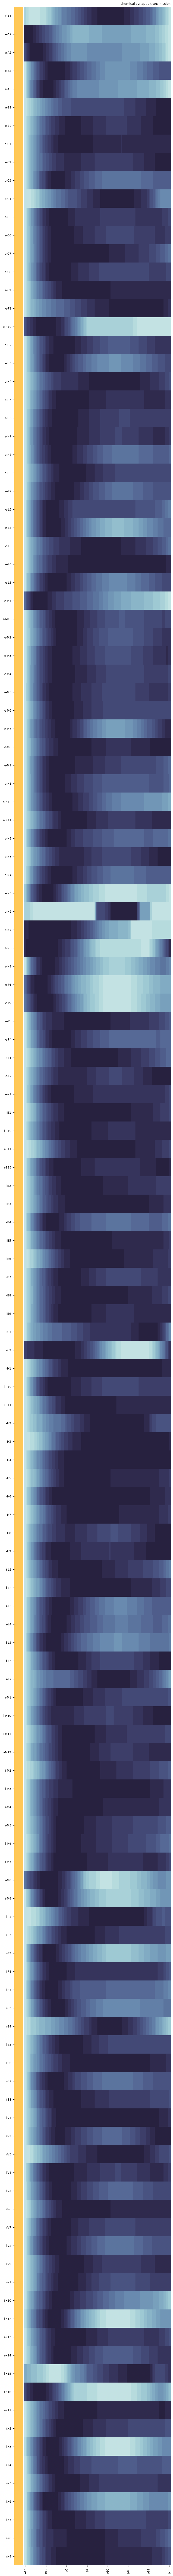

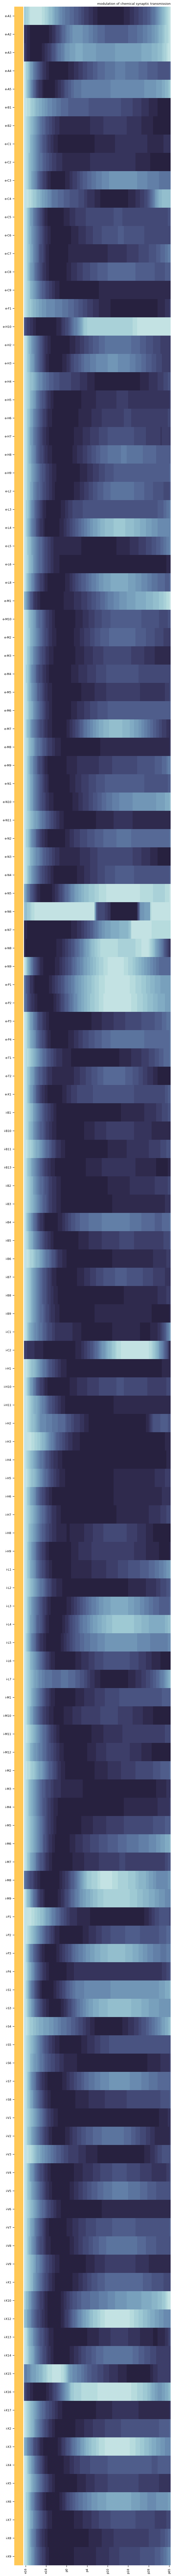

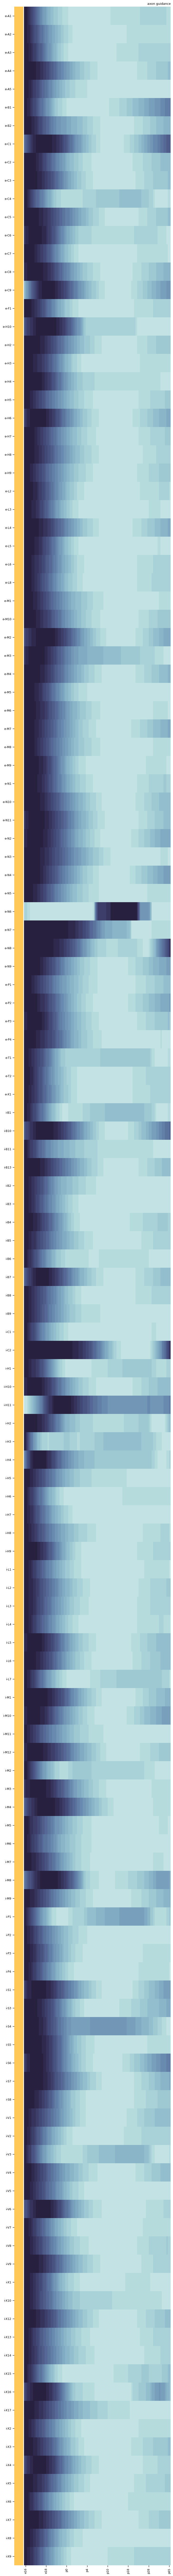

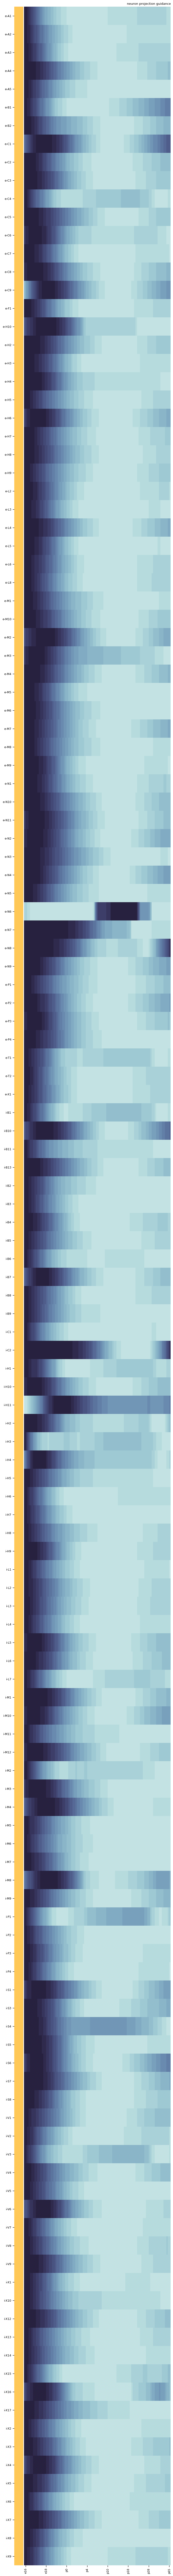

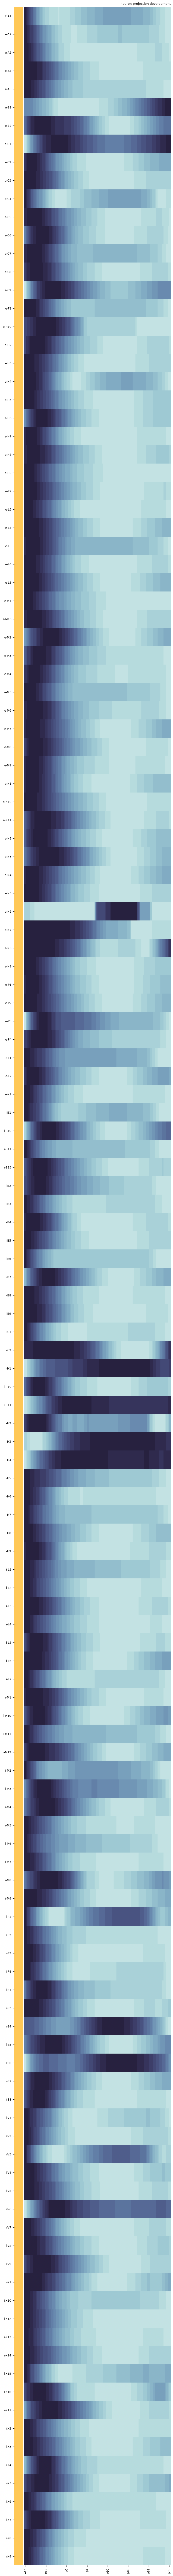

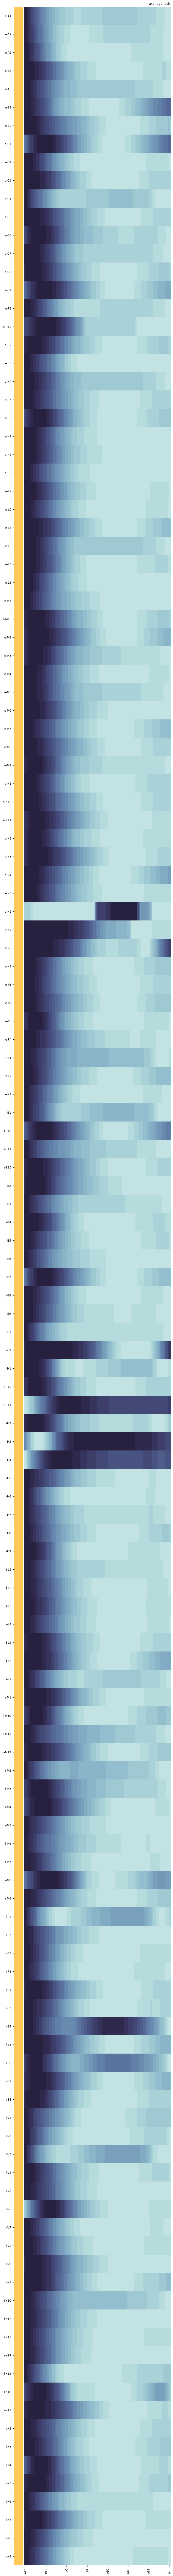

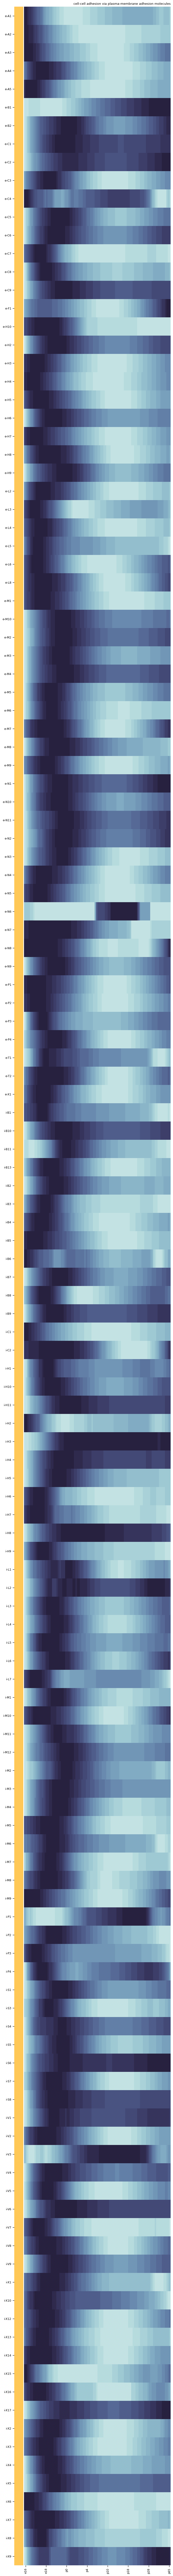

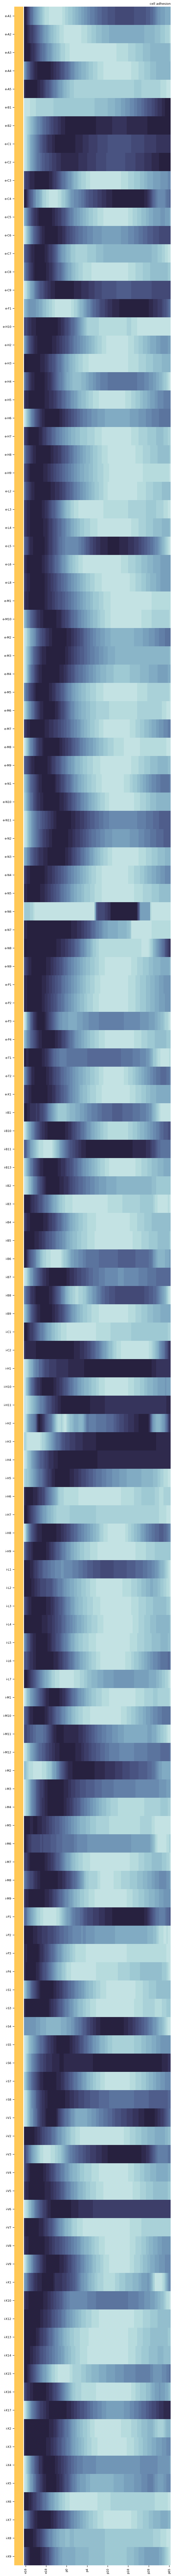

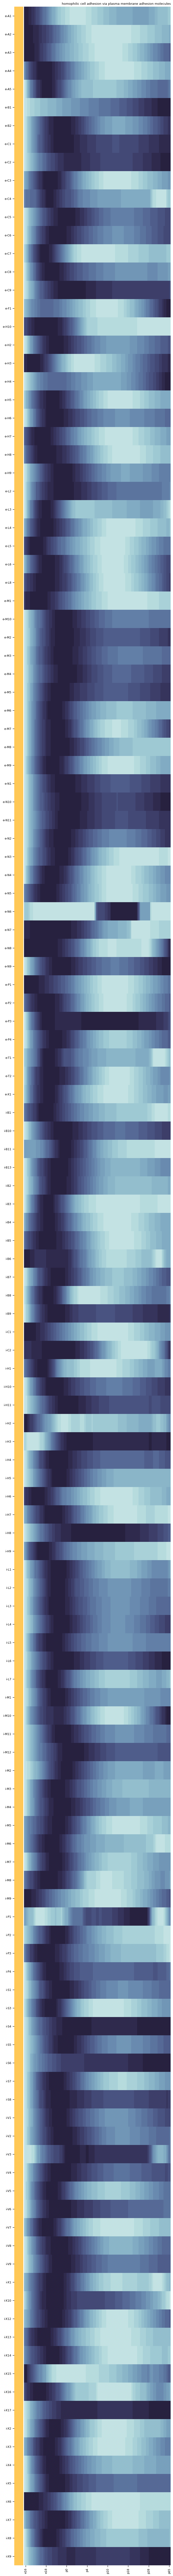

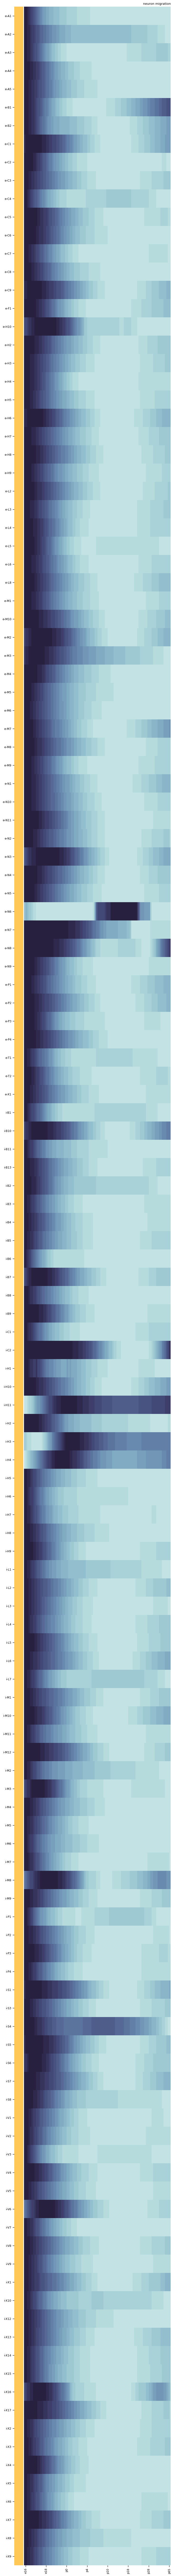

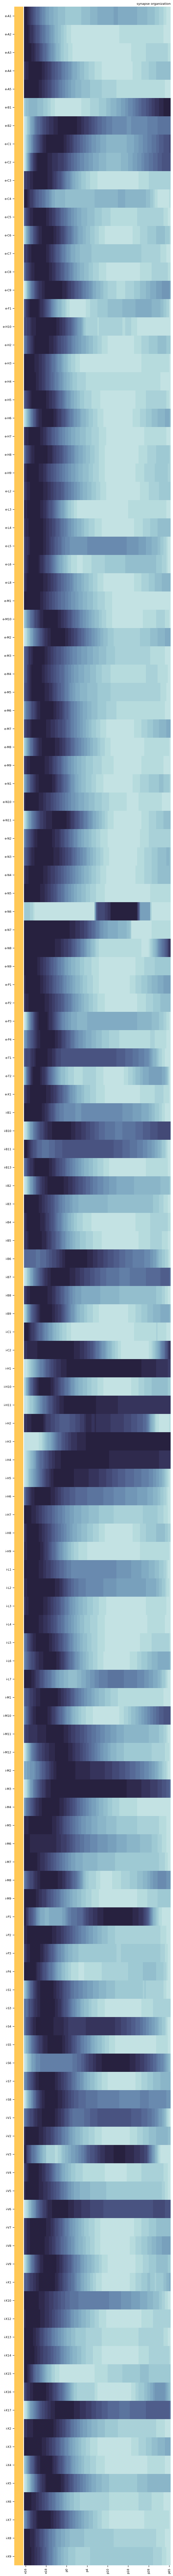

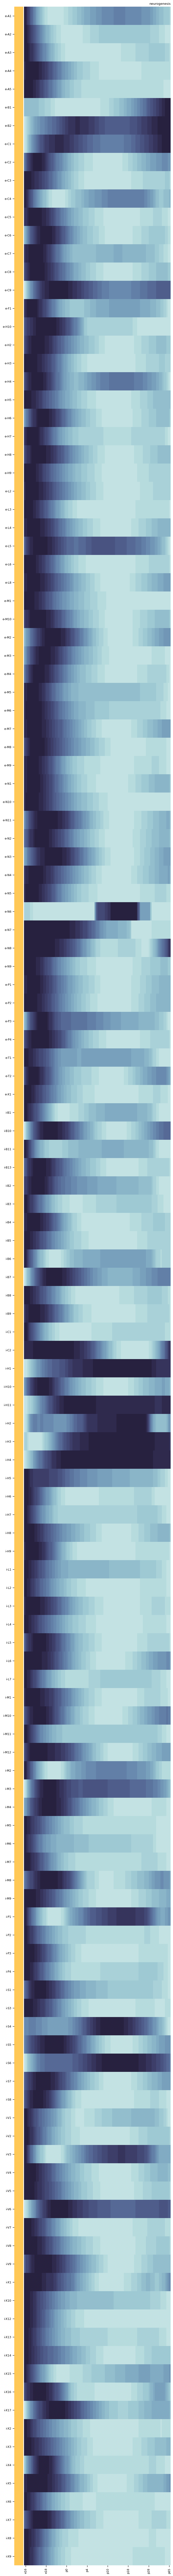

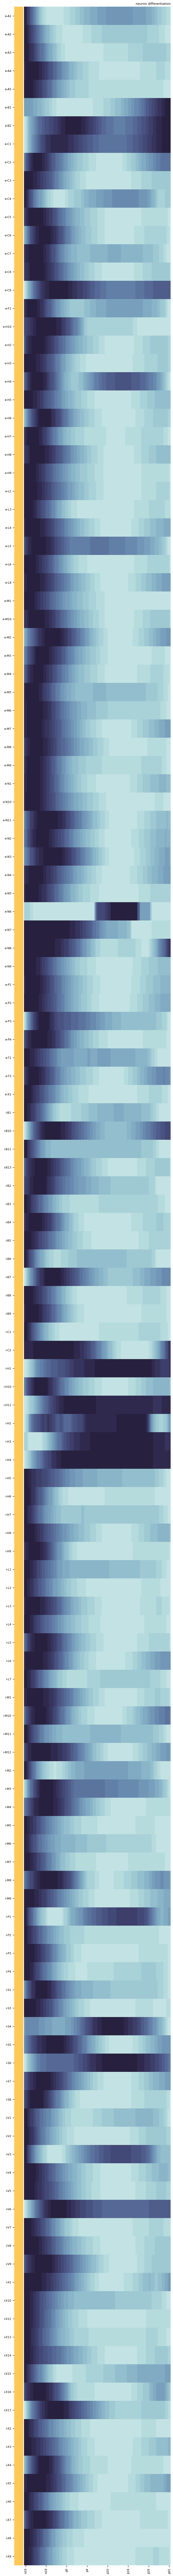

In [25]:
# plot additional categories - non enriched but we would like to see them
# with all cell types included, make on plot per GO category
# presynaptic membrane assembly' - won't plot
goes = ['synapse assembly',
        'synaptic signaling',
        'neurotransmitter receptor activity',
        'chemical synaptic transmission',
        'modulation of chemical synaptic transmission',
        'axon guidance',
        'neuron projection guidance',
        'neuron projection development',
        'axonogenesis',
        'cell-cell adhesion via plasma-membrane adhesion molecules',
        'cell adhesion',
        'homophilic cell adhesion via plasma membrane adhesion molecules',
        'neuron migration',        
        'synapse organization',        
        'neurogenesis',
        'neuron differentiation'
       ]

gene_cluster = pd.read_csv("data/dev_deg_v8/gene_cluster_ids.csv")
go_celltypes_dict = {}
fig_n = 0
for gg in goes:
    term_genes = GO_terms[gg].tolist()
    # get list of cell types having DEG with genes in that GO term
    # it might be all cell types, or less
    subset = gene_cluster[[x in term_genes for x in gene_cluster["gene_name"]]]
    # print(subset["cell_type"].value_counts())
    go_celltypes = sorted(np.unique(subset["cell_type"]).tolist())
        
    # color scale for expression
    cmap = sns.color_palette("ch:start=.2,rot=-.3", n_colors = 20)

    widths = [0.5, 8]
    height = len(go_celltypes)
    # /3
    
    fig = plt.figure(constrained_layout = False, 
                     figsize = (sum(widths), height))   

    plot_vals_dict = {}
    # loop through goes to get average expression
    #for itr, (go_itr, glc_itr) in enumerate(zip(goes[fig_n], goes[fig_n])):
    spec = fig.add_gridspec(ncols=2, nrows = 1, 
                            width_ratios = widths,
                            height_ratios = [height])
    spec.update( wspace = 0.01, hspace =0.05)
    ax = fig.add_subplot(spec[0, 1])
    df_itr = pd.DataFrame([],
                          columns = good_fits['i-B1'].columns.values,
                          index = go_celltypes,
                          dtype = float)
    # get average trend expression
    for key_itr in go_celltypes:
        df_itr.loc[key_itr] = eigen_val(gg, key_itr)        
        # df_itr.loc[key_itr] = trends_avg( GO_terms[go_itr], good_fits[key_itr])
        # normalize rows 0 to 1
    df_itr = df_itr.subtract(df_itr.min(axis=1), axis=0)\
            .divide(df_itr.max(axis=1) - df_itr.min(axis=1), axis=0)\
            .combine_first(df_itr)
    # plot_vals_dict[glc_itr] = df_itr
    ### right plot
    # print(cmap)
    
    # non-clustered heatmap
    cg = sns.heatmap(df_itr, 
                     ax = ax, cmap = cmap, xticklabels = False, yticklabels=False, cbar=False)
    cg.set_title(gg, loc = 'right')
    
    # clustered map
    # cg = sns.clustermap(df_itr, metric='euclidean', method='ward', 
    #                col_cluster=False, row_cluster=True, cmap=cmap, 
    #                figsize=(15,15), standard_scale=0)
    #cg.set_title(gg, loc = 'right')
    #cg.ax_row_dendrogram.set_visible(False)
    
    # remove ticks for subplots
    # cg.tick_params( bottom=False)
    # rotate y labels
    plt.setp(cg.yaxis.get_majorticklabels(), rotation=0)
    go_title = gg
    # ax.text( 1.005, 0.50, go_title, transform=ax.transAxes, ha='left', va='center')
    ticks = np.linspace( 1.0, n_grid_pts-1.0, num_stages)
    ax.set_xticks( ticks)
    ax.set_xticklabels(xlabels, rotation=90)
    
    
    ### left plot
    # add color blocks for each major-cluster
    #for itr, glc_itr in enumerate(goes[fig_n]):
    ax = fig.add_subplot(spec[0, 0])
    cell_list = go_celltypes
    for i, cell_itr in enumerate(cell_list[::-1]):
        yy = 1 * i
        # Create a Rectangle patch
        rect = patches.Rectangle((0.0,yy), 0.5, 1.0, color=color_dict[cell_itr])
        # Add the patch to the Axes
        ax.add_patch(rect)
    ax.set_xlim(0,0.5)
    ax.set_ylim(0,len(cell_list))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticklabels(cell_list[::-1])
    ax.set_yticks( np.linspace(0.5, len(cell_list)-0.5, len(cell_list)))
    plt.savefig(f"data/dev_deg_v8/nb16.fig4_{fig_n}.png")
    fig_n = fig_n + 1
    

In [159]:
v_terms = list(GO_terms.keys())
term = "neurotransmitter transport"
for s in v_terms:
    if s.find(term) >= 0:
        print(s)
        print(len(GO_terms[gg].tolist()))

neurotransmitter transport
188
regulation of neurotransmitter transport
188
negative regulation of neurotransmitter transport
188
positive regulation of neurotransmitter transport
188


In [177]:
# plot additional categories - non enriched but we would like to see them
# also add clustering
# with all cell types included, make on plot per GO category
# 'presynaptic membrane assembly',
# goes = ['synapse assembly',
#        'synaptic signaling',
#        'neurotransmitter receptor activity',
#        'chemical synaptic transmission',
#        'modulation of chemical synaptic transmission',
#        'axon guidance',
#        'neuron projection guidance',
#        'neuron projection development',
#        'axonogenesis',
#        'cell-cell adhesion via plasma-membrane adhesion molecules',
#        'cell adhesion',
#        'homophilic cell adhesion via plasma membrane adhesion molecules',
#        'neuron migration',
#        'synapse organization',        
#        'neurogenesis',
#        'neuron differentiation'
#       ]
gene_cluster = pd.read_csv("data/dev_deg_v8/gene_cluster_ids.csv")
import statistics

# GO terms from Supplemental T2 - SynGO
term = "neuronal"
goes = []
v_terms = list(GO_terms.keys())
for s in v_terms:
    if s.find(term) >= 0:
        term_genes = GO_terms[s].tolist()        
        subset = gene_cluster[[x in term_genes for x in gene_cluster["gene_name"]]]        
        total_genes = subset["cell_type"].value_counts().tolist()
        if len(total_genes) > 0:
            median_genes = statistics.median(total_genes)
            print(f"{s} {median_genes} {min(total_genes)}")
            if median_genes >= 40:
                goes.append(s)        
go_remove = ["regulation of neurotransmitter levels", "neurotransmitter transport", "neurotransmitter secretion",
            "signal release from synapse"]
for f in go_remove:
    if f in goes:
        goes.remove(f)
                
                
go_celltypes_dict = {}
fig_n = 0
for gg in goes:
    print(gg)
    term_genes = GO_terms[gg].tolist()
    # get list of cell types having DEG with genes in that GO term
    # it might be all cell types, or less
    subset = gene_cluster[[x in term_genes for x in gene_cluster["gene_name"]]]
    # total_genes = subset["cell_type"].value_counts()
    # print(sum(total_genes.tolist()))
    go_celltypes = sorted(np.unique(subset["cell_type"]).tolist())
        
    # color scale for expression
    cmap = sns.color_palette("ch:start=.2,rot=-.3", n_colors = 20)

    widths = [0.5, 8]
    height = len(go_celltypes)
    # /3
    
    fig = plt.figure(constrained_layout = False, 
                     figsize = (sum(widths), 
                                height))   

    plot_vals_dict = {}
    # loop through goes to get average expression
    #for itr, (go_itr, glc_itr) in enumerate(zip(goes[fig_n], goes[fig_n])):
    spec = fig.add_gridspec(ncols=2, nrows = 1, 
                            width_ratios = widths,
                            height_ratios = [height])
    spec.update( wspace = 0.01, hspace =0.05)
    ax = fig.add_subplot(spec[0, 1])
    df_itr = pd.DataFrame([],
                          columns = good_fits['i-B1'].columns.values,
                          index = go_celltypes,
                          dtype = float)
    # get average trend expression
    for key_itr in go_celltypes:
        df_itr.loc[key_itr] = eigen_val(gg, key_itr)        
        # df_itr.loc[key_itr] = trends_avg( GO_terms[go_itr], good_fits[key_itr])
        # normalize rows 0 to 1
    df_itr = df_itr.subtract(df_itr.min(axis=1), axis=0)\
            .divide(df_itr.max(axis=1) - df_itr.min(axis=1), axis=0)\
            .combine_first(df_itr)
    # plot_vals_dict[glc_itr] = df_itr
    ### right plot          
    # clustered map
    ticks = np.linspace( 1.0, n_grid_pts-1.0, num_stages)    
    ax = sns.clustermap(df_itr, metric='euclidean', method='ward', 
                    col_cluster=False, 
                    row_cluster=True, cmap=cmap, 
                    figsize = (15, 15), standard_scale=0,
                    yticklabels = True)
    ax.cax.set_visible(False)
    ax.ax_heatmap.set_title(gg, loc = 'right')
    ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_ymajorticklabels(), fontsize = 5)
    
    ax.ax_row_dendrogram.set_visible(False)
    
    ordered_cell_types = ax.ax_heatmap.yaxis.get_majorticklabels()
    otypes = [x.get_text() for x in ordered_cell_types]
    d_csv = df_itr.reindex(otypes)    
    d_csv.to_csv(f"data/dev_deg_v8_syngo/nb16.fig5_{gg}.csv")
    
    num_stages = len(stage_order)
    ax.ax_heatmap.set_xticks(ticks)
    #ax.ax_heatmap.set_xticklabels(stage_order, rotation=90);
    ax.ax_heatmap.set_xticklabels(xlabels, rotation = 90)
    ax.ax_row_dendrogram.set_visible(False)
    ax.ax_heatmap.yaxis.tick_left()
    # fig.setp(ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)    
    
    
    # remove ticks for subplots
    # cg.tick_params( bottom=False)
    # rotate y labels
    # plt.setp(cg.yaxis.get_majorticklabels(), rotation=0)
    
    #ax.set_xticks(ticks)
    #ax.set_xticklabels(xlabels, rotation=90)
    
    ### left plot
    # add color blocks for each major-cluster
    #for itr, glc_itr in enumerate(goes[fig_n]):
    #ax = fig.add_subplot(spec[0, 0])
    #cell_list = go_celltypes
    #for i, cell_itr in enumerate(cell_list[::-1]):
    #    yy = 1 * i
        # Create a Rectangle patch
    #    rect = patches.Rectangle((0.0,yy), 0.5, 1.0, color=color_dict[cell_itr])
        # Add the patch to the Axes
    #    ax.add_patch(rect)
    #ax.set_xlim(0,0.5)
    #ax.set_ylim(0,len(cell_list))
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    #ax.set_xticks([])
    #ax.set_yticklabels(cell_list[::-1])
    #ax.set_yticks( np.linspace(0.5, len(cell_list)-0.5, len(cell_list)))
    # plt.savefig(f"data/dev_deg_v8_syngo/nb16.fig5_{fig_n}.png", dpi = 300)
    plt.savefig(f"data/dev_deg_v8_syngo/nb16.fig5_{gg}.png", dpi = 300)
    fig_n = fig_n + 1

neuronal action potential propagation 4.0 1
neuronal action potential 11 1
neuronal-glial interaction involved in cerebral cortex radial glia guided migration 1.0 1
cell-cell adhesion involved in neuronal-glial interactions involved in cerebral cortex radial glia guided migration 1.0 1
gonadotrophin-releasing hormone neuronal migration to the hypothalamus 2 1
commitment of neuronal cell to specific neuron type in forebrain 1 1
neuronal-glial interaction involved in hindbrain glial-mediated radial cell migration 1 1
neuronal signal transduction 3 1
neuronal stem cell division 1.0 1
neuronal ion channel clustering 5.0 1
regulation of neuronal synaptic plasticity 22 2
regulation of long-term neuronal synaptic plasticity 11 1
positive regulation of long-term neuronal synaptic plasticity 3 1
regulation of short-term neuronal synaptic plasticity 8 1
negative regulation of short-term neuronal synaptic plasticity 1 1
neuronal stem cell population maintenance 2.0 1
regulation of neuronal action

In [189]:

df_itr[90:99]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
i-X17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
i-X2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
i-X3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
i-X4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
i-X5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
i-X6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
i-X7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
i-X8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
i-X9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [185]:
fig_n

14

## Statistical Testing Plots

In [54]:
out_path = "../data/"

In [55]:
num_cuts = np.array( [0,20,40,60,80,100])
arc_cuts = num_cuts#np.arcsinh( num_cuts / 0.55) #whole_adata2.uns['arcsinh_cofact'])
age_cuts = stage_order

In [56]:
import matplotlib as mpl
from matplotlib import cm

def plot_color_bar( x1, x2):
    sort_arcages = arc_cuts
    fig = plt.figure()
    ax = fig.add_axes([0.1, 0.1, 0.80, 0.05])
    viridis = cm.get_cmap('viridis', 256)
    cb = mpl.colorbar.ColorbarBase( ax, orientation='horizontal', cmap=viridis, 
                                    norm=mpl.colors.Normalize(0,100),
                                    ticks=sort_arcages)
    cb.set_ticklabels( age_cuts) #age_order);
    ax.set_xticklabels( age_cuts, rotation='vertical')
    ax.xaxis.set_ticks_position('top')
    ax.vlines( x1, 0, 100, colors='Red', linewidth=3.0);
    ax.vlines( x2, 0, 100, colors='Red', linewidth=3.0);
#     ax.arrow( x1, 50, x2-x1, 0.1, head_width=0.5, head_length=0.3, linewidth=3, color='Red', length_includes_head=True)
    ax.annotate( s='', xy=(x1,50), xytext=(x2,50), arrowprops=dict(arrowstyle='<-', color='Red'))
    return(ax)

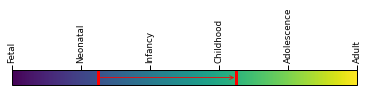

In [57]:
plot_color_bar( 25,65)

## Wilcoxon Testing of Eigentrends

In [58]:
from scipy.stats import wilcoxon
sns.set_theme(context="paper",font_scale=1.75)

In [59]:
def wilco( go, rr, tt, rs1, ts1, rs2=100, ts2=100, pvd=plot_vals_dict, alt="greater"):
    df = pvd[go]
    x = df.loc[rr].values[rs1:rs2]
    y = df.loc[tt].values[ts1:ts2]
    return( wilcoxon( x, y, zero_method='pratt', alternative=alt)[1])

In [60]:
def loop_wilco( ref, test, go, r_start, t_start, r_stop, t_stop):
    df = pd.DataFrame( [], index=[ref], columns=test, dtype=float)
    p_max = -999999
    for tt in test:
        wil_res = wilco( go, ref, tt, r_start, t_start, rs2=r_stop, ts2=t_stop)
        df.loc[ref,tt] = wil_res
        if p_max<wil_res:
            p_max = wil_res
        print( f"{ref} vs {tt} = {wil_res} ...sig={wil_res<0.05}")
    print( p_max)
    return( df)

In [61]:
#left, bottom, width, height
def cluster_map( df, go):
    ax = sns.clustermap( data=df, row_cluster=False, col_cluster=False,
                        row_colors=[color_dict[ii] for ii in df.index],
                        col_colors=[color_dict[ii] for ii in df.columns],
                        colors_ratio=(0.02,0.2),
                        dendrogram_ratio=(0.01,0.1),
                        cbar_pos=(0.045, 0.001, 0.92, 0.05), 
                        cbar_kws={"orientation":"horizontal"},
                        figsize=(2*len(test),2),
                        annot=True, cmap='Reds', linewidths=0.2);
    plt.setp(ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    plt.setp(ax.ax_heatmap.xaxis.get_majorticklabels(), rotation=0)
    # ax.ax_cbar.set_title('p-values')
    ax.ax_heatmap.xaxis.set_label_position('top')
    ax.fig.suptitle(f"{go} pvalues");
    ax.fig.savefig( out_path+f"heatmap_{go}_{df.index.values}.svg", format='svg', bbox_inches='tight')
    return

"Notably, ID2 INs show expression through to adulthood (Fig. 2E), suggesting that ID2 INs undergo extended migration into infancy and beyond."

In [67]:
go = 'neuron migration'
ref = 'ID2'
test = plot_vals_dict[go].index
test = test[test!=ref]
df = loop_wilco( ref=ref,
            test=test,
            go=go,
            r_start=40, r_stop=100,
            t_start=40, t_stop=100)

ID2 vs VIP = 8.570746990858083e-12 ...sig=True
ID2 vs LAMP5_CA1 = 1.819456954256536e-11 ...sig=True
ID2 vs SST = 8.354023216054315e-12 ...sig=True
ID2 vs PV = 8.354023216054315e-12 ...sig=True
ID2 vs PV_SCUBE3 = 8.354023216054315e-12 ...sig=True
ID2 vs Astro = 1.4902864511822716e-11 ...sig=True
ID2 vs OPC = 0.0037257677960571105 ...sig=True
ID2 vs Oligo = 0.001578600321070996 ...sig=True
0.0037257677960571105


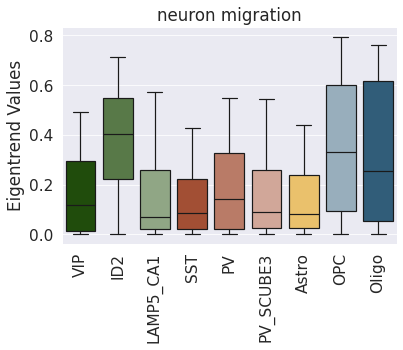

In [68]:
ax = sns.boxplot( data=plot_vals_dict[go].iloc[:,40:100].T, palette=color_dict);
plt.setp(ax.get_xticklabels(), rotation=90);
ax.set_title(f"{go}")
ax.set_ylabel('Eigentrend Values')
ax.figure.savefig( out_path+f"barplot_{go}_{ref}.svg", format='svg', bbox_inches='tight')

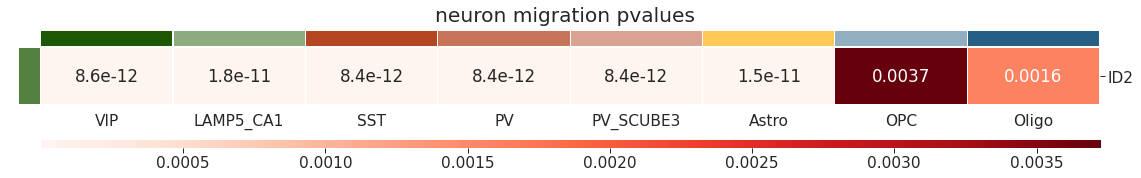

In [69]:
cluster_map( df, go)

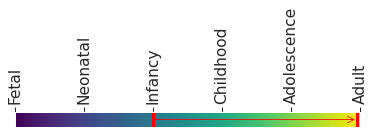

In [70]:
ax = plot_color_bar( 40, 99)
ax.figure.savefig( out_path+f"colorbar_{go}_{df.index.values}.svg", format='svg', bbox_inches='tight')

"The eigentrend for “neuron projection development” suggests peak dendritic growth continues into childhood for deeper layer PNs with delayed dendritic growth again seen for VIP/ID2 INs"

In [71]:
go = 'neuron projection development'
ref = 'ID2'
test = plot_vals_dict[go].index
test = test[test!=ref]
df1 = loop_wilco( ref=ref,
            test=test,
            go=go,
            r_start=40, r_stop=100,
            t_start=40, t_stop=100)

ID2 vs L2-3_CUX2 = 0.7845614168565139 ...sig=False
ID2 vs L4_RORB = 8.354023216054315e-12 ...sig=True
ID2 vs L5-6_THEMIS = 6.196188022879488e-09 ...sig=True
ID2 vs L5-6_TLE4 = 2.6567561152792056e-10 ...sig=True
ID2 vs VIP = 8.925908718976533e-09 ...sig=True
ID2 vs LAMP5_CA1 = 9.015193154818344e-12 ...sig=True
ID2 vs SST = 8.354023216054315e-12 ...sig=True
ID2 vs PV = 8.354023216054315e-12 ...sig=True
ID2 vs PV_SCUBE3 = 8.354023216054315e-12 ...sig=True
ID2 vs Astro = 1.2824001381314157e-11 ...sig=True
ID2 vs OPC = 0.9999999999918522 ...sig=False
ID2 vs Oligo = 0.9996458387843469 ...sig=False
0.9999999999918522


In [72]:
go = 'neuron projection development'
ref = 'VIP'
test = plot_vals_dict[go].index
test = test[test!=ref]
df2 = loop_wilco( ref=ref,
            test=test,
            go=go,
            r_start=45, r_stop=70,
            t_start=45, t_stop=70)

VIP vs L2-3_CUX2 = 0.9999938548388949 ...sig=False
VIP vs L4_RORB = 7.85255000987501e-06 ...sig=True
VIP vs L5-6_THEMIS = 1.1284095314026846e-05 ...sig=True
VIP vs L5-6_TLE4 = 6.1451611051242046e-06 ...sig=True
VIP vs ID2 = 0.9985265042728344 ...sig=False
VIP vs LAMP5_CA1 = 6.1451611051242046e-06 ...sig=True
VIP vs SST = 6.1451611051242046e-06 ...sig=True
VIP vs PV = 6.1451611051242046e-06 ...sig=True
VIP vs PV_SCUBE3 = 6.1451611051242046e-06 ...sig=True
VIP vs Astro = 6.1451611051242046e-06 ...sig=True
VIP vs OPC = 0.9999938548388949 ...sig=False
VIP vs Oligo = 0.9999938548388949 ...sig=False
0.9999938548388949


In [73]:
df = pd.concat( [df1,df2])

In [109]:

def cluster_map( df, go):
    ax = sns.clustermap( data=df, row_cluster=False, col_cluster=False,
                        row_colors=[color_dict[ii] for ii in df.index],
                        col_colors=[color_dict[ii] for ii in df.columns],
                        colors_ratio=(0.02,0.2),
                        dendrogram_ratio=(0.01,0.1),
                        #left, bottom, width, height
                        cbar_pos=(0.225, 0.001, 0.7, 0.05), 
                        cbar_kws={"orientation":"horizontal"},
                        figsize=(2*len(test),2),
                        annot=True, cmap='Reds', linewidths=0.2);
    plt.setp(ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    plt.setp(ax.ax_heatmap.xaxis.get_majorticklabels(), rotation=0)
    # ax.ax_cbar.set_title('p-values')
    ax.ax_heatmap.xaxis.set_label_position('top')
    ax.fig.suptitle(f"{go} pvalues");
    ax.fig.savefig( out_path+f"heatmap_{go}_{df.index.values}.svg", format='svg', bbox_inches='tight')
    return

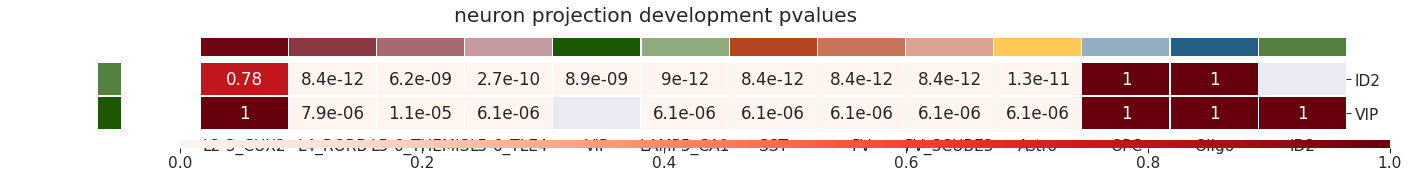

In [110]:
cluster_map( df, go)

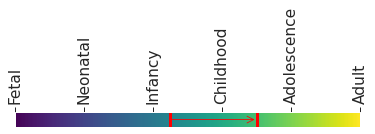

In [111]:
ax = plot_color_bar( 45, 70)
ax.figure.savefig( out_path+f"colorbar_{go}_{df.index.values}.svg", format='svg', bbox_inches='tight')

"Two distinct programs of neuron projection development, depending on local or global circuit connections, were evident in PN eigentrend (Fig. 2E). L4-RORB and L5/6-TLE4 neuron eigentrend peaks in fetal development, coinciding with known timing of thalamic axons reaching the cortical plate of the neocortex and forming early sensory-related circuits, as determined by neuroimaging studies (29, 30). In contrast, L2/3-CUX2 and L5/6-THEMIS showed highest eigentrend values after birth, suggesting that local projections become more concentrated at this time (29)."

In [144]:
plot_vals_dict[go].index.values

array(['L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS', 'L5-6_TLE4', 'VIP', 'ID2',
       'LAMP5_CA1', 'SST', 'PV', 'PV_SCUBE3', 'Astro', 'OPC', 'Oligo'],
      dtype=object)

In [145]:
loop_wilco( ref='L4_RORB',
        test=['L2-3_CUX2','L5-6_THEMIS','L5-6_TLE4'],
        go='neuron projection development',
        r_start=0, r_stop=20,
        t_start=0, t_stop=20)

L4_RORB vs L2-3_CUX2 = 4.428728843931774e-05 ...sig=True
L4_RORB vs L5-6_THEMIS = 4.428728843931774e-05 ...sig=True
L4_RORB vs L5-6_TLE4 = 0.6455473452623182 ...sig=False
0.6455473452623182


In [146]:
loop_wilco( ref='L5-6_TLE4',
        test=['L2-3_CUX2','L5-6_THEMIS','L4_RORB'],
        go='neuron projection development',
        r_start=0, r_stop=20,
        t_start=0, t_stop=20)

L5-6_TLE4 vs L2-3_CUX2 = 4.428728843931774e-05 ...sig=True
L5-6_TLE4 vs L5-6_THEMIS = 4.428728843931774e-05 ...sig=True
L5-6_TLE4 vs L4_RORB = 0.3544526547376819 ...sig=False
0.3544526547376819


In [148]:
loop_wilco( ref='L2-3_CUX2',
        test=['L4_RORB','L5-6_TLE4','L5-6_THEMIS'],
        go='neuron projection development',
        r_start=20, r_stop=60,
        t_start=20, t_stop=60)

L2-3_CUX2 vs L4_RORB = 1.4514620977608931e-06 ...sig=True
L2-3_CUX2 vs L5-6_TLE4 = 0.0009092378739857393 ...sig=True
L2-3_CUX2 vs L5-6_THEMIS = 0.0011918244923356032 ...sig=True
0.0011918244923356032


In [149]:
loop_wilco( ref='L5-6_THEMIS',
        test=['L4_RORB','L5-6_TLE4','L2-3_CUX2'],
        go='neuron projection development',
        r_start=20, r_stop=60,
        t_start=20, t_stop=60)

L5-6_THEMIS vs L4_RORB = 4.8853458907770425e-06 ...sig=True
L5-6_THEMIS vs L5-6_TLE4 = 0.0007565841381471061 ...sig=True
L5-6_THEMIS vs L2-3_CUX2 = 0.9988081755076644 ...sig=False
0.9988081755076644
